In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
import os
from windrose import WindroseAxes
import matplotlib.pyplot as plt
# Ensure all columns are shown horizontally
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)  # You can increase this if needed

# Loading Benin Data


In [ ]:
# Load Benin data
df_benin = pd.read_csv('../../data/raw/benin-malanville.csv')


# 1. Summary Statistics & Missing-Value Report


In [ ]:
# Overview of the numeric columns of benin data
# This shows count, mean, std dev, min, max, and quartiles
print("Overview of the numeric columns of benin data")
print(df_benin.describe())
# Overview of the categorical columns of benin data
# This shows the number of unique values, top value, and frequency of the top value
print("................................... ")
print("Overview of the categorical columns of benin data")
print(df_benin.describe(include='object'))
# Overview of all columns of benin data
print("................................... ")
print("Overview of all columns of benin data")  
print(df_benin.describe(include='all'))
# Overview of the dataset, the first 5 rows
print("................................... ")   
print("Overview of the dataset, the first 5 rows")
print(df_benin.head(5))
# Overview of the dataset, the last 5 rows
print("................................... ")   
print("Overview of the dataset, the last 5 rows")
print(df_benin.tail(5))
# Overview of the dataset, the random 5 rows
print("................................... ")
print("Overview of the dataset, the random 5 rows")
print(df_benin.sample(5))
# Overview of the dataset, the shape of the dataset
print("................................... ")
print("Overview of the dataset, the shape of the dataset")
print(df_benin.info())
# Check for missing values
print("................................... ")
print("Check for missing values")
print(df_benin.isnull().sum())
print("................................... ")
# Columns with >5% missing values
print("\nColumns with more than 5% missing values:")
# Calculate the percentage of missing values for each column
missing_percent = df_benin.isnull().mean() * 100

# Filter columns with more than 5% missing values and print them
cols_above_5pct_null = missing_percent[missing_percent > 5]
print(cols_above_5pct_null)


# 2. Outlier Detection & Basic Cleaning

In [ ]:
print("Starting outlier and missing value analysis...")

# Define key columns to check
key_columns = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']
# Check missing values in key columns
print("Missing values in key columns before imputation:")
print(df_benin[key_columns].isnull().sum())
print("................................... ")
# Calculate Z-scores
z_scores = df_benin[key_columns].apply(zscore)

# Flag outliers (|Z| > 3)
outliers = (np.abs(z_scores) > 3)

# Count of outliers per column
print("Number of outliers in each key column:")
print(outliers.sum())
print("................................... ")

# Rows flagged as outliers in any key column
print("Rows flagged as outliers in any key column:")
outlier_rows = df_benin[outliers.any(axis=1)]
print(f"Total rows with outliers in any key column: {len(outlier_rows)}")
print("................................... ")

# Impute outliers (|Z| > 3) with median of the column
print("Impute outliers (|Z| > 3) with median of the column")
for col in key_columns:
    median_val = df_benin[col].median()
    df_benin.loc[outliers[col], col] = median_val
    print(f"{outliers[col].sum()} outliers in '{col}' replaced with median ({median_val})")
print("................................... ")


# Confirm no missing values remain
print("Remaining missing values after imputation:")
print(df_benin[key_columns].isnull().sum())
print("................................... ")



# Exporting cleaned Benin data to CSV

In [ ]:
# Exporting cleaned Benin data to CSV (do NOT commit this to Git)
df_benin.to_csv('../../data/clean/benin_clean.csv', index=False)


# 3. Time Series Analysis


In [ ]:
# Convert Timestamp to datetime if not already
df_benin['Timestamp'] = pd.to_datetime(df_benin['Timestamp'], errors='coerce')

# Set Timestamp as index (if not already)
df_benin.set_index('Timestamp', inplace=True)


# Plot GHI, DNI, DHI, and Tamb
plt.figure(figsize=(16, 8))

plt.subplot(2, 2, 1)
df_benin['GHI'].plot()
plt.title('Global Horizontal Irradiance (GHI) Over Time')
plt.ylabel('GHI (W/m²)')

plt.subplot(2, 2, 2)
df_benin['DNI'].plot()
plt.title('Direct Normal Irradiance (DNI) Over Time')
plt.ylabel('DNI (W/m²)')

plt.subplot(2, 2, 3)
df_benin['DHI'].plot()
plt.title('Diffuse Horizontal Irradiance (DHI) Over Time')
plt.ylabel('DHI (W/m²)')

plt.subplot(2, 2, 4)
df_benin['Tamb'].plot()
plt.title('Ambient Temperature (Tamb) Over Time')
plt.ylabel('Temperature (°C)')

plt.tight_layout()
plt.show()

# Add month column
df_benin['Month'] = df_benin.index.month

# Monthly mean plots
monthly_means = df_benin.groupby('Month')[['GHI', 'DNI', 'DHI', 'Tamb']].mean()

monthly_means.plot(kind='bar', figsize=(10,6))
plt.title('Monthly Average of GHI, DNI, DHI, Tamb')
plt.ylabel('Value')
plt.xlabel('Month')
plt.xticks(rotation=0)
plt.grid(True)
plt.tight_layout()
plt.show()




# 4. Cleaning Impact

In [ ]:

# Group by 'Cleaning' and calculate average of ModA and ModB
cleaning_impact = df_benin.groupby('Cleaning')[['ModA', 'ModB']].mean()

# Display the averages
print("Average ModA and ModB values grouped by Cleaning status:")
print(cleaning_impact)

# Plot the impact of cleaning on ModA and ModB
cleaning_impact.plot(kind='bar', figsize=(8, 5))
plt.title('Impact of Cleaning on ModA & ModB Sensor Readings')
plt.ylabel('Average Sensor Value')
plt.xlabel('Cleaning Status')
plt.xticks(rotation=0)
plt.grid(True)
plt.tight_layout()
plt.show()

# 5. Correlation and Relationship Analysis


In [ ]:
# Correlation matrix
corr_matrix = df_benin[['GHI', 'DNI', 'DHI', 'TModA', 'TModB']].corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap - Solar and Module Temperatures")
plt.tight_layout()
plt.show()

# Scatter plots for each pair of variables
# WS vs GHI
print("Scatter plot of Wind Speed vs. Global Horizontal Irradiance (GHI):")
plt.scatter(df_benin['WS'], df_benin['GHI'], alpha=0.5)
plt.title('Wind Speed vs. Global Horizontal Irradiance (GHI)')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('GHI (W/m²)')
plt.grid(True)
plt.show()

# RH vs Tamb
print("Scatter plot of Relative Humidity vs. Ambient Temperature:")
plt.scatter(df_benin['RH'], df_benin['Tamb'], alpha=0.5, color='orange')
plt.title('Relative Humidity vs. Ambient Temperature')
plt.xlabel('Relative Humidity (%)')
plt.ylabel('Tamb (°C)')
plt.grid(True)
plt.show()


# 6. Wind and Distribution Analysis

In [ ]:
# Drop NaNs from wind columns
wind_data = df_benin[['WS', 'WD']].dropna()

# Create Windrose plot
print("windrose plot WS/WD")
ax = WindroseAxes.from_ax()
ax.bar(wind_data['WD'], wind_data['WS'], normed=True, opening=0.8, edgecolor='white')
ax.set_legend()
plt.title('Wind Rose: Wind Speed vs Wind Direction')
plt.show()

# Histogram for GHI
print("Histogram for GHI")
plt.figure(figsize=(10, 4))
plt.hist(df_benin['GHI'].dropna(), bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of GHI (Global Horizontal Irradiance)')
plt.xlabel('GHI')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Histogram for WS (Wind Speed)
print("Histogram for Wind Speed (WS)")
plt.figure(figsize=(10, 4))
plt.hist(df_benin['WS'].dropna(), bins=30, color='salmon', edgecolor='black')
plt.title('Distribution of Wind Speed (WS)')
plt.xlabel('Wind Speed')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


# 7. Temperature Analysis

In [ ]:

# Drop rows with missing values in these columns to avoid plot issues
rh_temp_ghi = df_benin[['RH', 'Tamb', 'GHI']].dropna()

# Scatter plot RH vs Tamb
print("Scatter plot of Relative Humidity (RH) vs Ambient Temperature (Tamb):")
plt.figure(figsize=(7,5))
sns.scatterplot(data=rh_temp_ghi, x='RH', y='Tamb', color='teal')
plt.title('Relative Humidity (RH) vs Ambient Temperature (Tamb)')
plt.xlabel('Relative Humidity (%)')
plt.ylabel('Ambient Temperature (°C)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Scatter plot RH vs GHI
print("Scatter plot of Relative Humidity (RH) vs Global Horizontal Irradiance (GHI):")
plt.figure(figsize=(7,5))
sns.scatterplot(data=rh_temp_ghi, x='RH', y='GHI', color='purple')
plt.title('Relative Humidity (RH) vs Global Horizontal Irradiance (GHI)')
plt.xlabel('Relative Humidity (%)')
plt.ylabel('GHI (W/m²)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Correlation matrix for RH, Tamb, GHI
print("Correlation matrix for RH, Tamb, GHI:")
corr = rh_temp_ghi.corr()
print("Correlation matrix:")
print(corr[['RH', 'Tamb', 'GHI']])



# 8. Bubble Chart

Scatter plot of Relative Humidity (RH) vs Ambient Temperature (Tamb):


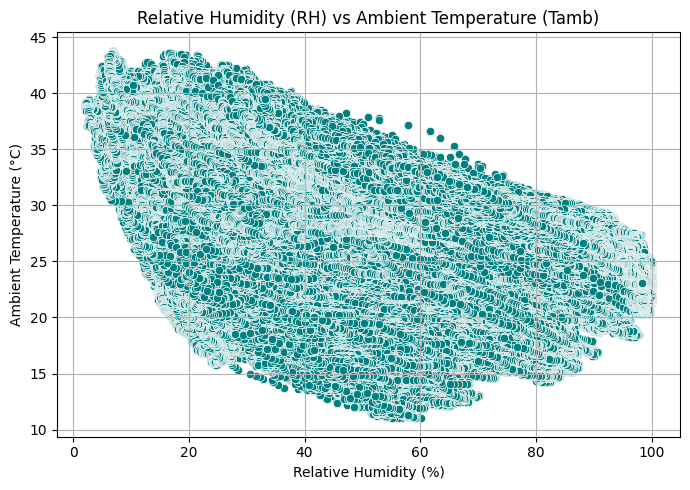

Scatter plot of Relative Humidity (RH) vs Global Horizontal Irradiance (GHI):


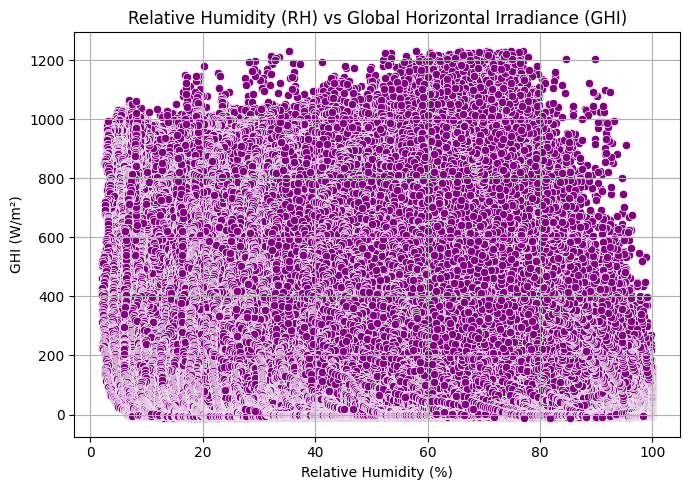

Correlation matrix for RH, Tamb, GHI:
Correlation matrix:
            RH      Tamb       GHI
RH    1.000000 -0.414842 -0.360629
Tamb -0.414842  1.000000  0.547698
GHI  -0.360629  0.547698  1.000000


In [54]:
import seaborn as sns
import matplotlib.pyplot as plt

# Drop rows with missing values in these columns to avoid plot issues
rh_temp_ghi = df_benin[['RH', 'Tamb', 'GHI']].dropna()

# Scatter plot RH vs Tamb
print("Scatter plot of Relative Humidity (RH) vs Ambient Temperature (Tamb):")
plt.figure(figsize=(7,5))
sns.scatterplot(data=rh_temp_ghi, x='RH', y='Tamb', color='teal')
plt.title('Relative Humidity (RH) vs Ambient Temperature (Tamb)')
plt.xlabel('Relative Humidity (%)')
plt.ylabel('Ambient Temperature (°C)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Scatter plot RH vs GHI
print("Scatter plot of Relative Humidity (RH) vs Global Horizontal Irradiance (GHI):")
plt.figure(figsize=(7,5))
sns.scatterplot(data=rh_temp_ghi, x='RH', y='GHI', color='purple')
plt.title('Relative Humidity (RH) vs Global Horizontal Irradiance (GHI)')
plt.xlabel('Relative Humidity (%)')
plt.ylabel('GHI (W/m²)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Correlation matrix for RH, Tamb, GHI
print("Correlation matrix for RH, Tamb, GHI:")
corr = rh_temp_ghi.corr()
print("Correlation matrix:")
print(corr[['RH', 'Tamb', 'GHI']])


